## Установка пакетов

In [6]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [7]:
!pip install torcheval transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.


In [8]:
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from tqdm import tqdm
import tensorflow_datasets as tfds

import zipfile

from sklearn.model_selection import train_test_split
import torch

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [9]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  print('GPU not found, your device: {}'.format(device_name))
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Анализ датасета

In [7]:
FILE_IDS = {
    "Subtask A": "1CAbb3DjrOPBNm0ozVBfhvrEh9P9rAppc",
    "Subtask B": "11YeloR2eTXcTzdwI04Z-M2QVvIeQAU6-",
    "Subtask C": "16bRUuoeb_LxnCkcKM-ed6X6K5t_1C6mL"
}

In [10]:
train_path = "SubtaskA/subtaskA_train_monolingual.jsonl"
test_path = "SubtaskA/subtaskA_dev_monolingual.jsonl"

In [11]:
!gdown --folder https://drive.google.com/drive/folders/1CAbb3DjrOPBNm0ozVBfhvrEh9P9rAppc

Retrieving folder contents
Processing file 1e_G-9a66AryHxBOwGWhriePYCCa4_29e subtaskA_dev_monolingual.jsonl
Processing file 123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL subtaskA_dev_multilingual.jsonl
Processing file 1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG subtaskA_train_monolingual.jsonl
Processing file 13-9-DakCeLFbPgCiVIU0v6_BCQx0ppz6 subtaskA_train_multilingual.jsonl
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1e_G-9a66AryHxBOwGWhriePYCCa4_29e
To: /content/SubtaskA/subtaskA_dev_monolingual.jsonl
100% 10.8M/10.8M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL
To: /content/SubtaskA/subtaskA_dev_multilingual.jsonl
100% 21.2M/21.2M [00:00<00:00, 55.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG
From (redirected): https://drive.google.com/uc?id=1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6

In [12]:
df = pd.read_json(train_path, lines=True)
df

,text,label,model,source,id
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4
...,...,...,...,...,...
119752,"The paper is an interesting contribution, prim...",0,human,peerread,119752
119753,\nWe thank the reviewers for all their comment...,0,human,peerread,119753
119754,The authors introduce a semi-supervised method...,0,human,peerread,119754
119755,This paper proposes the Neural Graph Machine t...,0,human,peerread,119755


In [13]:
df = df.sample(10000)

In [14]:
from transformers import AutoTokenizer

model_name = 'FacebookAI/roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
def input_for_analisis(df, tokenizer):
    input_ids_lengths = np.zeros((len(df), 1))
    train_labels = np.zeros((len(df), 1))
    for i, labels in tqdm(enumerate(df['label']), total=len(df)):
        train_labels[i] = labels

    for i, text in tqdm(enumerate(df['text']), total=len(df)):
        tokens = tokenizer.encode(
            text,
            add_special_tokens = True, # add [CLS], [SEP]
        )
        input_ids_lengths[i] = len(tokens)

    return input_ids_lengths, train_labels

In [16]:
train_ids_lengths, train_labels = input_for_analisis(df, tokenizer)
labels2lengths = np.zeros((2, len(df)), dtype=np.int32)
labels2lengths[0] = train_labels[:, 0]
labels2lengths[1] = train_ids_lengths[:, 0]

np.save('labels2lengths.npy', labels2lengths)

100%|██████████| 10000/10000 [00:37<00:00, 265.95it/s]


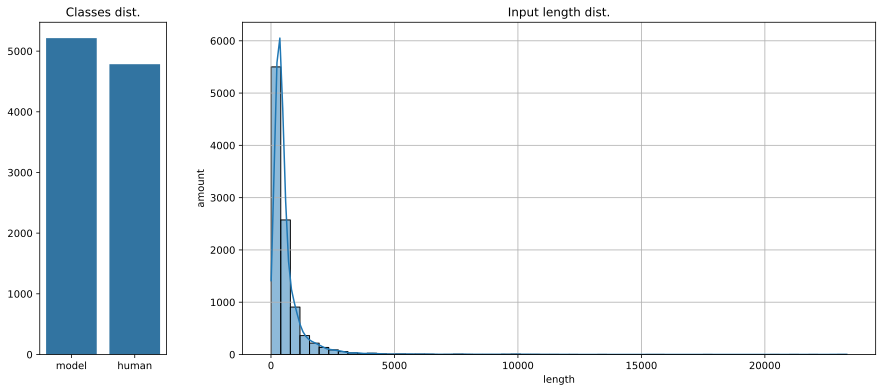

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols=2, width_ratios=(1, 5), figsize=(15, 6))
sns.barplot(
    x=['model', 'human'],
    y=[len(np.where(train_labels == 0)[0]), len(np.where(train_labels == 1)[0])],
    ax=ax[0],
)
sns.histplot(labels2lengths[1], kde=True, ax=ax[1], bins=60)
ax[0].set_title('Classes dist.')
ax[1].set_title('Input length dist.')
ax[1].set_xlabel('length')
ax[1].grid(True)
plt.ylabel('amount')
plt.show()

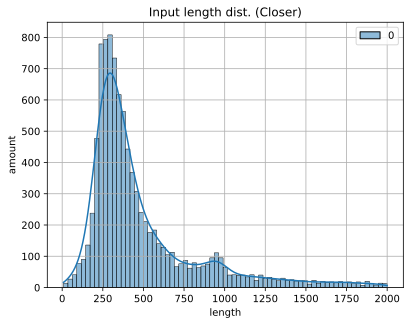

In [18]:
sns.histplot(train_ids_lengths[np.where(labels2lengths[1] <= 2000)], kde=True)
plt.ylabel('amount')
plt.xlabel('length')
plt.title('Input length dist. (Closer)')
plt.grid(True)
plt.show()

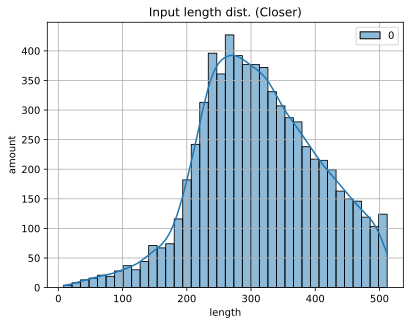

Amount of texts with length less than 512 tokens: 6866


In [19]:
sns.histplot(train_ids_lengths[np.where(labels2lengths[1] <= 512)], kde=True)
plt.ylabel('amount')
plt.xlabel('length')
plt.title('Input length dist. (Closer)')
plt.grid(True)
plt.show()
print('Amount of texts with length less than 512 tokens: {}'.format(len(train_ids_lengths[np.where(labels2lengths[1] <= 512)])))

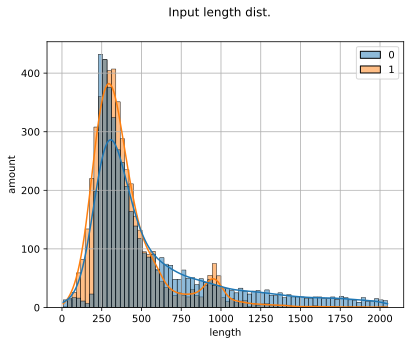

In [20]:
sns.histplot(
    x=train_ids_lengths[np.where(train_ids_lengths <= 2048)[0]].flatten(),
    hue=labels2lengths[0][np.where(train_ids_lengths <= 2048)[0]],
    kde=True
)
plt.ylabel('amount')
plt.xlabel('length')
plt.grid(True)
plt.suptitle('Input length dist.')
plt.show()

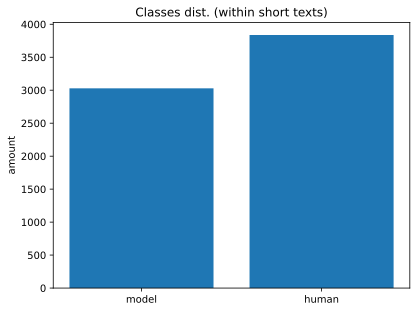

In [21]:
shorten_l2l = labels2lengths[:, np.where(labels2lengths[1] <= 512)]
plt.bar(['model', 'human'], [len(np.where(shorten_l2l[0] == 0)[0]), len(np.where(shorten_l2l[0] == 1)[0])])
plt.ylabel('amount')
plt.title('Classes dist. (within short texts)')
plt.show()

In [22]:
# Сохраняем позиции коротких текстов

short_texts_positions = np.where(labels2lengths[1] <= 512)[0]
np.save('short_texts_positions.npy', short_texts_positions)

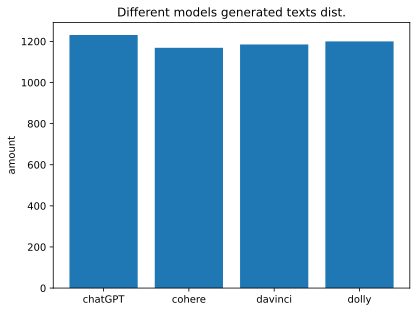

In [23]:
length_dist = [np.where(df['model'] == model)[0] for model in np.unique(df['model']) if model != 'human']
plt.bar(np.unique(df['model'])[:-1],
         [len(elem) for elem in length_dist]
)
plt.ylabel('amount')
plt.title('Different models generated texts dist.')
plt.show()

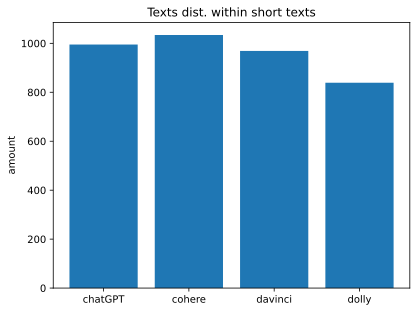

In [24]:
plt.bar(np.unique(df['model'])[:-1],
         [len(np.where(labels2lengths[1][elem] <= 512)[0]) for elem in length_dist]
)
plt.ylabel('amount')
plt.title('Texts dist. within short texts')
plt.show()

### Возьмем часть на которой возможно обучаться при малых ресурсах

In [26]:
df = df.iloc[short_texts_positions]

## Строим модель на  TensofFlow

In [27]:
from transformers import RobertaModel

bert_model = RobertaModel.from_pretrained(model_name, trainable=True)
max_seq_length = 512

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="attention_mask")

last_hidden_state = bert_model(input_ids, attention_mask=attention_mask).last_hidden_state

cls_output = last_hidden_state[:, 0, :]

#pooler_output = bert_model(input_ids, attention_mask=attention_mask).pooler_output

x = tf.keras.layers.Dense(64, activation='gelu', name="hidden_layer_1")(cls_output)
x = tf.keras.layers.Dense(32, activation='gelu', name="hidden_layer_2")(x)
#x = tf.keras.layers.Dropout(0.1)(x)
out = tf.keras.layers.Dense(1, activation=None, name="outputs")(x)
out = tf.keras.activations.sigmoid(out)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_model (TFXLM  TFBaseModelOutputWithPooli   2780436   ['input_ids[0][0]',           
 RobertaModel)               ngAndCrossAttentions(last_   48         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

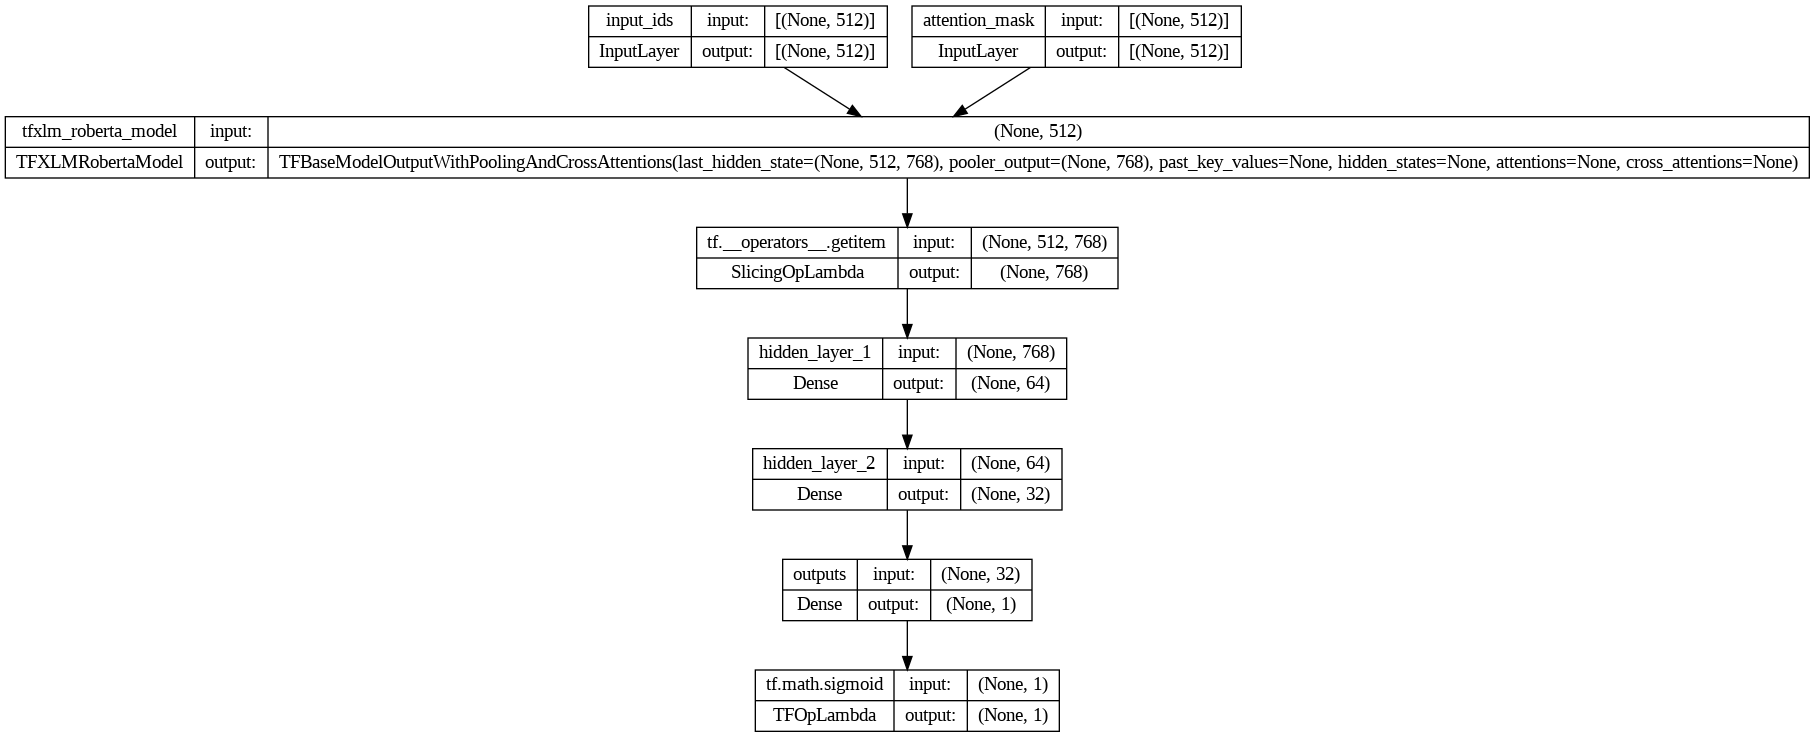

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Предобработка данных для подачи в BERT

In [28]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained(model_name)
print("used model: {}".format(model_name))

used model: FacebookAI/roberta-base


In [29]:
def input_for_model(df, tokenizer, max_seq_length):
    input_ids = np.zeros((len(df), max_seq_length), dtype=np.int32)
    input_attention_masks = np.zeros((len(df), max_seq_length), dtype=np.int32)
    train_labels = np.zeros((len(df), 1), dtype=np.int32)

    if 'label' in df.columns:
        train_labels[:, 0] = df['label']

    for i, sequence in tqdm(enumerate(df['text']), total=len(df)):
        tokens = tokenizer.encode_plus(
            sequence,
            max_length = max_seq_length, # max length of the text that can go to BERT
            truncation=True,
            padding='max_length',
            add_special_tokens = True, # add [CLS], [SEP]
            return_token_type_ids = False,
            return_attention_mask = True, # add attention mask to not focus on pad tokens
            return_tensors = 'pt'
        )
        input_ids[i,:], input_attention_masks[i,:] = tokens['input_ids'], tokens['attention_mask']

    if 'label' in df.columns:
        return input_ids, input_attention_masks, train_labels
    else:
        return input_ids, input_attention_masks

### Не УД

In [30]:
train_ids, train_attention_mask, train_labels = input_for_model(
    df=df,
    tokenizer=tokenizer,
    max_seq_length=512
)

100%|██████████| 6866/6866 [00:32<00:00, 209.27it/s]


In [31]:
X_train = np.array([train_ids, train_attention_mask])

In [32]:
X_train = X_train.transpose((1, 0, 2))
X_train.shape

(6866, 2, 512)

In [33]:
tokenizer.decode(X_train[1][0])

'<s> A child doesn’t change anything about their natural walking or running stride when they first start to kick a soccer ball. It is almost like the soccer ball just happens to get in the way of their natural stride. As we walk or run as humans our toe naturally points forward as it moves forward. Keeping the toe down would cause us to walk or run looking like a Clydesdale horse. Also, when we bring our leg forward there is VERY little clearance between the bottom of the foot and the ground. Pointing the toe down will cause it to hit the ground, often causing serious injury.;\n,, The leg comes back behind the player, returns OUT to the ball and then swings back around in front. The ball is struck with the "sweet spot" which is slightly on the inside of our foot, just above the big toe.\n\n, The player MUST maintain eye contact on the ball while performing the kick.\n\n,, Then hold a soccer ball over your foot. Let it fall and watch where it strikes your foot. It will hit the very top 

In [34]:
y_train = train_labels

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=SEED)

In [36]:
X_train = X_train.transpose((1, 0, 2))
X_val = X_val.transpose((1, 0, 2))

X_train.shape

(2, 5149, 512)

In [37]:
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)

## Обучение модели

In [38]:
# Если уже готовы данные
def load_dataset_from_zip(filename):
  z = zipfile.ZipFile(filename, 'r')
  z.extractall()

  train_inputs = np.load("train_inputs.npy")
  valid_inputs = np.load("valid_inputs.npy")
  train_outputs = np.load("train_outputs.npy")
  valid_outputs = np.load("valid_outputs.npy")
  return train_inputs, valid_inputs, train_outputs, valid_outputs

train_inputs, valid_inputs, train_outputs, valid_outputs = load_dataset_from_zip(
    '/content/drive/MyDrive/datasets/roberta_full_encoding.zip'
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datasets/roberta_full_encoding.zip'

In [ ]:
# если только сделали
train_inputs = np.load("train_inputs.npy")
valid_inputs = np.load("valid_inputs.npy")
train_outputs = np.load("train_outputs.npy")
valid_outputs = np.load("valid_outputs.npy")

In [ ]:
train_inputs = {'input_ids': train_inputs[0][:4], 'attention_mask': train_inputs[1][:4]}
valid_inputs = {'input_ids': valid_inputs[0][:4], 'attention_mask': valid_inputs[1][:4]}

In [ ]:
class SaveLogs(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.loss = list()
        self.acc = list()

    def on_batch_end(self, batch, logs=None):
        self.loss.append(logs.get("loss"))
        self.acc.append(logs.get("accuracy"))

In [ ]:
logger = SaveLogs()
#checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/datasets/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
model.layers[2].trainable = False
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

BATCH_SIZE = 4

history = model.fit(
    train_inputs,
    train_outputs[:4],
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=(valid_inputs, valid_outputs[:4]),
    callbacks=[logger]
)

Epoch 1/10
1/1 [==============================] - 42s 42s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.7077 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 37s 37s/step - loss: 0.6643 - accuracy: 0.5000 - val_loss: 0.7076 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 31s 31s/step - loss: 0.7386 - accuracy: 0.5000 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 32s 32s/step - loss: 0.6798 - accuracy: 0.5000 - val_loss: 0.7074 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 29s 29s/step - loss: 0.6905 - accuracy: 0.5000 - val_loss: 0.7073 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 40s 40s/step - loss: 0.6874 - accuracy: 0.5000 - val_loss: 0.7072 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 33s 33s/step - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.7071 - val_accuracy: 0.5000
Epoch 8/10
1/1 [===========

In [ ]:
with tf.device(device_name):
    model.layers[2].trainable = True
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

    BATCH_SIZE = 8
    history2 = model.fit(train_inputs,
                         train_outputs,
                         epochs=1,
                         batch_size=BATCH_SIZE,
                         validation_data=(valid_inputs, valid_outputs),
                         callbacks=[logger])

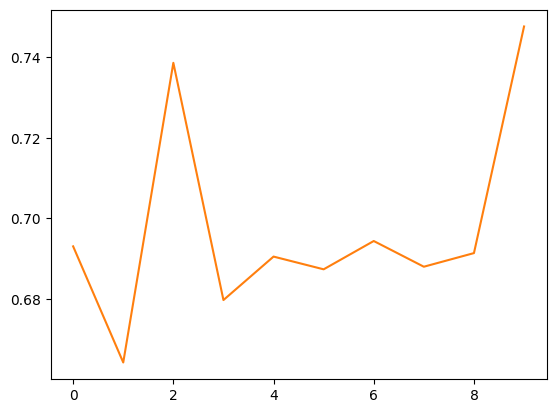

In [ ]:
plt.plot(np.arange(len(logger.loss)), logger.loss, c='tab:orange')
plt.show()

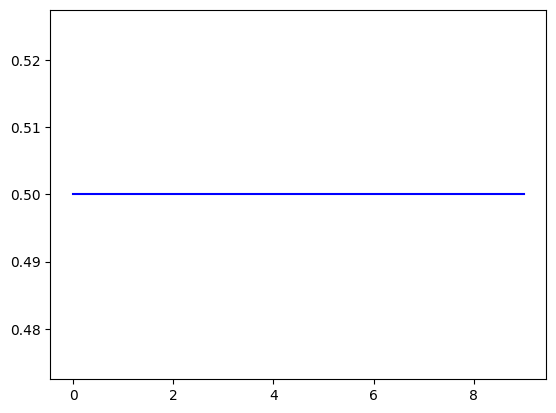

In [ ]:
plt.plot(np.arange(len(logger.acc)), logger.acc, c='blue')
plt.show()

In [ ]:
def show_res(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

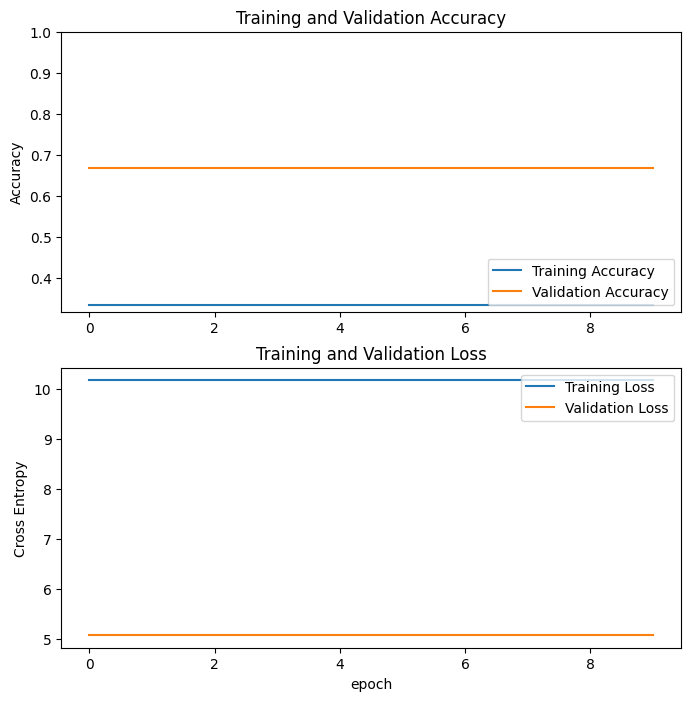

In [ ]:
show_res(history)

## Эксперименты с **Bert**


In [ ]:
from transformers import TFXLMRobertaModel
from transformers import AutoTokenizer

bert_model_name = 'jplu/tf-xlm-roberta-base'

bert_model = TFXLMRobertaModel.from_pretrained(bert_model_name, trainable=True)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

In [ ]:
data = pd.read_json(train_path, lines=True, nrows=10)
data.head()

,text,label,model,source,id
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4


In [ ]:
tokenized_text = tokens = bert_tokenizer.encode_plus(
          data['text'][1],
          max_length = 512, # max length of the text that can go to BERT
          truncation=True, padding='max_length',
          add_special_tokens = True, # add [CLS], [SEP]
          return_token_type_ids = False,
          return_attention_mask = True, # add attention mask to not focus on pad tokens
          return_tensors = 'tf'
      )

In [ ]:
tokenized_text['input_ids']

<tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[     0,  47184,    214,  73303,   1657,  40777,  27528,    100,
           935,  70616,   5140,     14,     83,     10,   7477,    136,
         23468,   9433,    450,    831,   2043,    398,   3060,  54704,
         27528,     47,  11301,     98,    935, 130250,      5,  17106,
            10,  10846,   8781,  98441,      4,    398,    831,    186,
         24649,   2852,     70,   8999,      7,    111,  54704,  70616,
         27528,     23,    110,   1733,      5,  11853,     25,      7,
          3642,     47,  22113,  73303,   1657,  40777,  27528,    100,
           935,  70616,   5140,     14,      5,  74644,  13806,    345,
          6953,     10,   5140,     14,  41097,      7,  23660,    615,
         26040,     10,  10846,   5140,     14,  41097,      7, 126381,
          1295,   6712, 101597,   1314,   1884,  13547, 156095,      5,
          4263,    398,   2301,     25,     18,  21771,    765,   3060,
             4, 

In [ ]:
bert_tokenizer.decode(tokenized_text['input_ids'][0])

'<s> Buying Virtual Console games for your Nintendo Wii is a fun and easy process that can net you some classic games to play on your console. With a few simple steps, you can be exploring the worlds of classic Nintendo games in no time. Here\'s how to buy Virtual Console games for your Nintendo Wii. Method 1: Using a Wii Points Card 1. Find a few Wii Points cards from game retailers like GameStop. If you don\'t already have some, go to your local game retailer and look for Wii Points cards. These are usually sold in increments of $10 or $20 and come with a code on the back that you will use to add points to your system. 2. Make sure your Wii is online and on a secure connection if possible. You\'ll need an internet connection to access the Wii Shop Channel and purchase Virtual Console games. If possible, make sure your console is connected to a secure network. 3. Open the Wii Shop Channel, and click Add Wii Points at the bottom right of your screen after the channel finishes loading. 

In [ ]:
embedding = bert_model(tokenized_text['input_ids'], tokenized_text['attention_mask'])

In [ ]:
embedding[1]

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.03088559,  0.2156627 ,  0.11957612,  0.49213192,  0.05201529,
         0.34972855,  0.42435437, -0.37914008,  0.19209154, -0.1504185 ,
         0.02766212,  0.12081306,  0.35141075,  0.36784577, -0.28230745,
        -0.21136528,  0.28646222,  0.35127068,  0.007324  , -0.22558588,
        -0.33022505,  0.40504393, -0.6886663 , -0.55175245, -0.23841529,
         0.594468  ,  0.1067994 , -0.29586318, -0.10711205,  0.6650996 ,
         0.15773094,  0.45078236, -0.26493812,  0.02361797,  0.12500265,
        -0.14952464,  0.43115446,  0.21771319,  0.49791968,  0.3430215 ,
         0.09989336, -0.14982876, -0.15393297,  0.16117287,  0.28732738,
        -0.21451896,  0.22497997, -0.03859591, -0.21052313,  0.4357992 ,
         0.5937107 , -0.16921178, -0.01038711,  0.06889085,  0.1716268 ,
         0.10858746,  0.3332365 , -0.3273423 , -0.26082313, -0.5411651 ,
        -0.0368453 ,  0.6417673 ,  0.4410404 ,  0.31204945,  0.33178404,
 

## Используем BertForSequenceClassification

In [76]:
# если только сделали
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
y_train = np.float32(np.load("y_train.npy").flatten()[:, None])
y_val = np.float32(np.load("y_val.npy").flatten()[:, None])

In [77]:
X_train = {'input_ids': X_train[0], 'attention_mask': X_train[1]}
X_val = {'input_ids': X_val[0], 'attention_mask': X_val[1]}

In [74]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
from torcheval.metrics import BinaryAccuracy
import pandas as pd

# Установка устройства (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
print(model)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [67]:
# Создание классификатора
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = model
        self.fc1 = nn.Linear(768, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_output = last_hidden_state[:, 0, :]
        x = self.fc1(cls_output)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [68]:
classifier = Classifier().to(device)

In [69]:
layers = [child for child in classifier.children()]

for param in layers[0].parameters():
    param.requires_grad = False

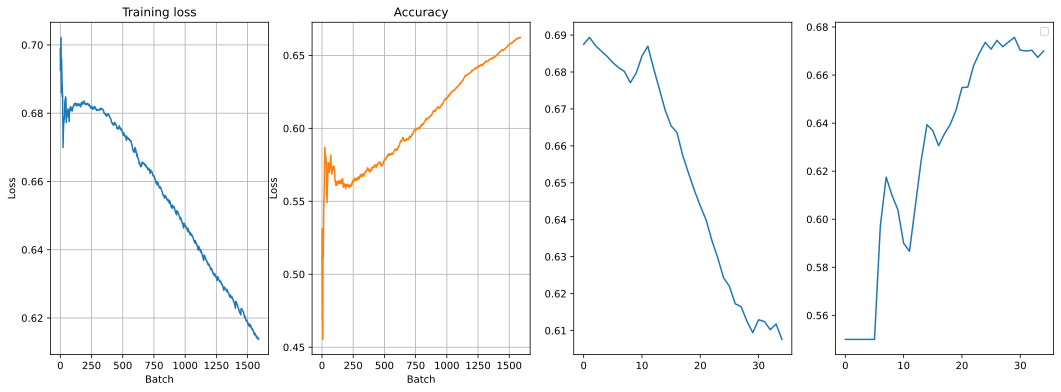

Loss на обучающей выборке: 153.98741


In [80]:
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

# Инициализация модели и оптимизатора
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.1)

# Функция потерь и обучение
criterion = nn.BCELoss()
metric = BinaryAccuracy()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

train_loss_cum = 0

num_epochs = 5
BATCH_SIZE = 16

val_ids = torch.tensor(X_val['input_ids'][:100]).to(device)
val_mask = torch.tensor(X_val['attention_mask'][:100]).to(device)
y_val = torch.tensor(y_val[:100]).to(device)

for epoch in range(num_epochs):
    for i, start in enumerate(range(0, y_train.shape[0], BATCH_SIZE)):
        idx = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0])
        stop = start + BATCH_SIZE

        input_ids = torch.tensor(
            X_train['input_ids'][idx][start:stop]
        ).to(device)
        attention_mask = torch.tensor(
            X_train['attention_mask'][idx][start:stop]
        ).to(device)
        label = torch.tensor(y_train[idx][start:stop]).to(device)

        output = classifier(input_ids, attention_mask)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_loss_cum += loss.item()
        metric.update(output[:, 0], label[:, 0])
        train_acc.append(metric.compute())

        if i % 50 == 0:
            with torch.no_grad():
                output = classifier(val_ids, val_mask)
                loss = criterion(output.cpu(), y_val.cpu())
                val_loss.append(loss)
                val_acc.append(accuracy_score(np.array(y_val.cpu()), np.where(output.cpu() > 0.5, 1, 0)))

            clear_output(True)
            fig, ax = plt.subplots(1, 4, figsize=(18, 6))
            ax[0].plot(np.cumsum(train_loss) / (np.arange(len(train_loss)) + 1))
            ax[2].plot(np.cumsum(val_loss) / (np.arange(len(val_loss)) + 1))
            ax[0].set_title("Training loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_ylabel("Loss")
            ax[0].grid(True)
            ax[1].plot(train_acc, c = 'tab:orange')
            ax[3].plot(np.cumsum(val_acc) / (np.arange(len(val_acc)) + 1))
            ax[1].set_title("Accuracy")
            ax[1].set_xlabel("Batch")
            ax[1].set_ylabel("Loss")
            ax[1].grid(True)
            plt.legend()
            plt.show()


print("Loss на обучающей выборке: {0:.5f}".format(train_loss_cum / 32 * num_epochs))

In [81]:
print("Loss на обучающей выборке: {0:.5f}".format(train_loss_cum / (y_train.shape[0] // BATCH_SIZE * num_epochs)))

Loss на обучающей выборке: 0.61403
